# Convolution Nets for MNIST

 
In the interest of time, you could sample a subset of observations (e.g. $1000$) that are a particular number of your choice (e.g. $6$) and $1000$ observations that aren't that particular number (i.e. $\neq 6$). 

We will build a model using that and see how it performs on the test dataset

In [1]:
#Import the required libraries
import numpy as np

from keras.datasets import mnist

/Users/venkat/anaconda3/envs/DL_Test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/venkat/anaconda3/envs/DL_Test/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

In [3]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

In [4]:
from keras.utils import np_utils
from keras.optimizers import SGD

## Loading Data

In [5]:
#Load the training and testing data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Dimension of Training set is : ", X_train.shape)

Dimension of Training set is :  (60000, 28, 28)


In [7]:
# Make a copy for plotting and comparison as we normalize the data
X_test_orig = X_test

## Data Preparation

### Very Important: 
When dealing with images & convolutions, it is paramount to handle `image_data_format` properly

In [8]:
from keras import backend as K

#### Preprocess and Normalize Data

In [9]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255


print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

print (" Comparing the Minumum of original and normalized", np.amin(X_test_orig), np.amin(X_test) )
print (" Comparing the Maximum of original and normalized", np.amax(X_test_orig), np.amax(X_test) )


X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
 Comparing the Minumum of original and normalized 0 0.0
 Comparing the Maximum of original and normalized 255 1.0


In [11]:
np.random.seed(1338)  # for reproducibilty!!

# Test data
X_test = X_test.copy()
Y = y_test.copy()

# Converting the output to binary classification(Six=1,Not Six=0)
Y_test = Y == 6
Y_test = Y_test.astype(int)

# Selecting the 5918 examples where the output is 6
print (" Number of examples where output is Six = ",  X_train[y_train == 6].shape[0])
X_six = X_train[y_train == 6].copy()
Y_six = y_train[y_train == 6].copy()

# Selecting the examples where the output is not 6
print (" Number of examples where output is NOT Six = ",  X_train[y_train != 6].shape[0])
X_not_six = X_train[y_train != 6].copy()
Y_not_six = y_train[y_train != 6].copy()



 Number of examples where output is Six =  5918
 Number of examples where output is NOT Six =  54082


In [13]:
# Selecting 6000 random examples from the data that 
# only contains the data where the output is not 6
random_rows = np.random.randint(0,X_six.shape[0],6000)
X_not_six = X_not_six[random_rows]
Y_not_six = Y_not_six[random_rows]

In [14]:
# Appending the data with output as 6 and data with output as <> 6
X_train = np.append(X_six,X_not_six)

# Reshaping the appended data to appropraite form
X_train = X_train.reshape((X_six.shape[0] + X_not_six.shape[0],) + shape_ord)

# Appending the labels and converting the labels to 
# binary classification(Six=1,Not Six=0)
Y_labels = np.append(Y_six,Y_not_six)
Y_train = Y_labels == 6 
Y_train = Y_train.astype(int)

In [15]:
print(X_train.shape, Y_labels.shape, X_test.shape, Y_test.shape)

(11918, 28, 28, 1) (11918,) (10000, 28, 28, 1) (10000,)


In [16]:
# Converting the classes to its binary categorical form
nb_classes = 2
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

# A simple CNN

In [17]:
# -- Initializing the values for the convolution neural network

nb_epoch = 2  # kept very low! Please increase if you have GPU

batch_size = 64
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

#### Step 1: Model Definition

In [18]:
model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), padding='valid', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

#### Step 2: Compile

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

#### Step 3: Fit

In [22]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 5s 443us/step - loss: 0.0097 - acc: 0.9963 - val_loss: 0.0446 - val_acc: 0.9854
Epoch 2/2
11918/11918 [==============================] - 6s 510us/step - loss: 0.0059 - acc: 0.9983 - val_loss: 0.0440 - val_acc: 0.9864


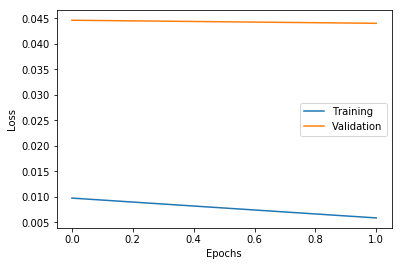

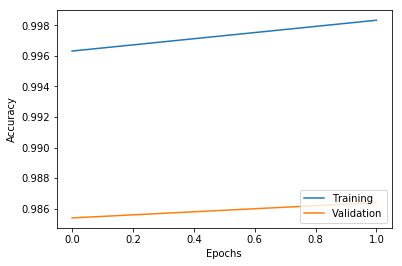

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

### Step 4: Evaluate

In [24]:
print('Available Metrics in Model: {}'.format(model.metrics_names))

Available Metrics in Model: ['loss', 'acc']


In [25]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 0.0440137590298953
Test Accuracy: 0.9864


### Let's plot our model Predictions!

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline

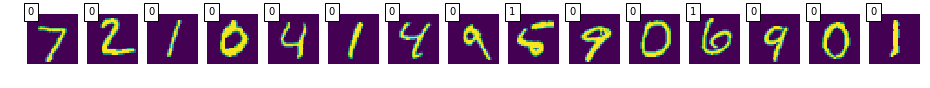

In [27]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

In [28]:
print (" Printing the Details of the Model")
print (model.summary())


 Printing the Details of the Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 43266     
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 43,586
Trainable params: 43,586
Non-trainable params: 0
_________________________________________________________________
None
Layer 0 	 conv2d_1 		 (None, 28, 28, 1) 	 (None, 26, 26, 32)
Layer 1 	 activation_1 		 (None, 26, 

In [ ]:
print ("More details about the model")
for i, layer in enumerate(model.layers):
    print ("Layer", i, "\t", layer.name, "\t\t", layer.input_shape, "\t", layer.output_shape)

# Adding more Dense Layers

In [39]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [40]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 16s 1ms/step - loss: 0.1963 - acc: 0.9456 - val_loss: 0.0869 - val_acc: 0.9720
Epoch 2/2
11918/11918 [==============================] - 18s 2ms/step - loss: 0.0897 - acc: 0.9707 - val_loss: 0.0889 - val_acc: 0.9686


In [41]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.08892997025996446
Test accuracy: 0.9686


# Adding Dropout

In [42]:
model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                        padding='valid',
                        input_shape=shape_ord))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 14s 1ms/step - loss: 0.2460 - acc: 0.9344 - val_loss: 0.1817 - val_acc: 0.9355
Epoch 2/2
11918/11918 [==============================] - 14s 1ms/step - loss: 0.1058 - acc: 0.9652 - val_loss: 0.0975 - val_acc: 0.9650


In [44]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.09748781638741494
Test accuracy: 0.965


# Adding more Convolution Layers

In [45]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
    
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [46]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 27s 2ms/step - loss: 0.3802 - acc: 0.8595 - val_loss: 0.1695 - val_acc: 0.9456
Epoch 2/2
11918/11918 [==============================] - 26s 2ms/step - loss: 0.1447 - acc: 0.9492 - val_loss: 0.0714 - val_acc: 0.9744


In [47]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.07140373645871878
Test accuracy: 0.9744


# Exercise

The above code has been written as a function. 

Change some of the **hyperparameters** and see what happens. 

In [32]:
# Function for constructing the convolution neural network
# Feel free to add parameters, if you want

def build_model():
    """"""
    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                     padding='valid',
                     input_shape=shape_ord))
    model.add(Activation('relu'))
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=nb_epoch,verbose=1,
              validation_data=(X_test, Y_test))
          

    #Evaluating the model on the test data    
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score)
    print('Test accuracy:', accuracy)

In [33]:
#Timing how long it takes to build the model and test it.
%timeit -n1 -r1 build_model()

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 28s 2ms/step - loss: 0.4198 - acc: 0.8350 - val_loss: 0.1762 - val_acc: 0.9438
Epoch 2/2
11918/11918 [==============================] - 28s 2ms/step - loss: 0.1431 - acc: 0.9509 - val_loss: 0.0692 - val_acc: 0.9759
Test score: 0.06924470479190349
Test accuracy: 0.9759
1min 1s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


---

## Understanding Convolutional Layers Structure

In this exercise we want to build a (_quite shallow_) network which contains two 
[Convolution, Convolution, MaxPooling] stages, and two Dense layers.

To test a different optimizer, we will use [AdaDelta](http://keras.io/optimizers/), which is a bit more complex than the simple Vanilla SGD with momentum.

In [34]:
from keras.optimizers import Adadelta

In [35]:
input_shape = shape_ord
nb_classes = 10

## [conv@32x3x3+relu]x2 --> MaxPool@2x2 --> DropOut@0.25 -->
## [conv@64x3x3+relu]x2 --> MaxPool@2x2 --> DropOut@0.25 -->
## Flatten--> FC@512+relu --> DropOut@0.5 --> FC@nb_classes+SoftMax
## NOTE: each couple of Conv filters must have `border_mode="same"` and `"valid"`, respectively

### Understanding layer shapes

An important feature of Keras layers is that each of them has an `input_shape` attribute, which you can use to visualize the shape of the input tensor, and an `output_shape` attribute, for inspecting the shape of the output tensor.

As we can see, the input shape of the first convolutional layer corresponds to the `input_shape` attribute (which must be specified by the user). 

In this case, it is a `28x28` image with three color channels. 

Since this convolutional layer has the `padding` set to `same`, its output width and height will remain the same, and the number of output channel will be equal to the number of filters learned by the layer, 16. 

The following convolutional layer, instead, have the default `padding`, and therefore reduce width and height by $(k-1)$, where $k$ is the size of the kernel. 

`MaxPooling` layers, instead, reduce width and height of the input tensor, but keep the same number of channels. 

`Activation` layers, of course, don't change the shape.

In [48]:
print (model.summary())

for i, layer in enumerate(model.layers):
    print ("Layer", i, "\t", layer.name, "\t\t", layer.input_shape, "\t", layer.output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_9 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_10 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
__________

### Understanding weights shape

In the same way, we can visualize the shape of the weights learned by each layer. 

In particular, Keras lets you inspect weights by using the `get_weights` method of a layer object. 

This will return a list with two elements, the first one being the **weight tensor** and the second one being the **bias vector**.

In particular:

- **MaxPooling layer** don't have any weight tensor, since they don't have learnable parameters. 


- **Convolutional layers**, instead, learn a $(n_o, n_i, k, k)$ weight tensor, where $k$ is the size of the kernel, $n_i$ is the number of channels of the input tensor, and $n_o$ is the number of filters to be learned. 

For each of the $n_o$ filters, a bias is also learned. 


- **Dense layers** learn a $(n_i, n_o)$ weight tensor, where $n_o$ is the output size and $n_i$ is the input size of the layer. Each of the $n_o$ neurons also has a bias.

In [37]:
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        W, b = layer.get_weights()
        print("Layer", i, "\t", layer.name, "\t\t", W.shape, "\t", b.shape)

Layer 0 	 conv2d_4 		 (3, 3, 1, 32) 	 (32,)
Layer 2 	 conv2d_5 		 (3, 3, 32, 32) 	 (32,)
Layer 7 	 dense_6 		 (4608, 128) 	 (128,)
Layer 10 	 dense_7 		 (128, 2) 	 (2,)


# Batch Normalisation

Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

## How to BatchNorm in Keras

```python
from keras.layers.normalization import BatchNormalization

BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                   beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                   moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                   beta_constraint=None, gamma_constraint=None)
```

#### Arguments

<ul>
<li><strong>axis</strong>: Integer, the axis that should be normalized
    (typically the features axis).
    For instance, after a <code>Conv2D</code> layer with
    <code>data_format="channels_first"</code>,
    set <code>axis=1</code> in <code>BatchNormalization</code>.</li>
<li><strong>momentum</strong>: Momentum for the moving average.</li>
<li><strong>epsilon</strong>: Small float added to variance to avoid dividing by zero.</li>
<li><strong>center</strong>: If True, add offset of <code>beta</code> to normalized tensor.
    If False, <code>beta</code> is ignored.</li>
<li><strong>scale</strong>: If True, multiply by <code>gamma</code>.
    If False, <code>gamma</code> is not used.
    When the next layer is linear (also e.g. <code>nn.relu</code>),
    this can be disabled since the scaling
    will be done by the next layer.</li>
<li><strong>beta_initializer</strong>: Initializer for the beta weight.</li>
<li><strong>gamma_initializer</strong>: Initializer for the gamma weight.</li>
<li><strong>moving_mean_initializer</strong>: Initializer for the moving mean.</li>
<li><strong>moving_variance_initializer</strong>: Initializer for the moving variance.</li>
<li><strong>beta_regularizer</strong>: Optional regularizer for the beta weight.</li>
<li><strong>gamma_regularizer</strong>: Optional regularizer for the gamma weight.</li>
<li><strong>beta_constraint</strong>: Optional constraint for the beta weight.</li>
<li><strong>gamma_constraint</strong>: Optional constraint for the gamma weight.</li>
</ul>

### Excercise

In [34]:
# Try to add a new BatchNormalization layer to the Model 
# (after the Dropout layer) - before or after the ReLU Activation

In [ ]:
---

## Addendum:

* [CNN on CIFAR10](cifar10_cnn.ipynb)